# Paper Statistics
This script will calculate the first insights into the submitted and accepted papers based on the data from `./data-proceedings/authors.csv`.

Author: Sven Mayer (info@sven-mayer.com)

LICENSE: GPL-3.0 license 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

colors = ["#FF523F","#FFAD33","#198D6D","#6599FF","#683b96","#f07adb"]

import geopandas
gdf = geopandas.read_file("./utils/ne_10m_admin_0_countries_lakes.shp")[['ADMIN', 'ADM0_A3', "geometry"]]#.to_crs('+proj=robin')
gdf = gdf.rename(columns = {"ADMIN":"Country", "ADM0_A3":"Alpha-3"})
dfISO3166 = pd.read_csv("./utils/ISO-3166-Countries-with-Regional-Codes.csv")
del gdf["Country"]
gdf= pd.merge(gdf, dfISO3166, on="Alpha-3", how="left")
gdf = gdf[~gdf.Country.isna()]
gdf = gdf[["Country", "Alpha-3", "Region", "Sub-Region", "geometry"]]

In [2]:
df = pd.read_csv("./data-proceedings/authors.csv")

dfCount = df.Url.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorContributionCount'})

if ("AuthorContributionCount" in df.columns):
    df = df.drop(columns=["AuthorContributionCount"])

df = pd.merge(df, dfCount, left_on='Url', right_on='Url', how='left')


dfCount = df.Doi.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorPaperCount'})

if ("AuthorPaperCount" in df.columns):
    df = df.drop(columns=["AuthorPaperCount"])

df = pd.merge(df, dfCount, left_on='Doi', right_on='Doi', how='left')

df["AuthorContribution"] = 1/df.AuthorPaperCount


print(len(df))
df.head()


3714


,Year,Doi,Title,Order,Name,Affiliation,Alpha-3,Url,Type,Session,AuthorContributionCount,AuthorPaperCount,AuthorContribution
0,2005,10.1145/1085777.1085779,NaN,1,Dan Hong,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100648888,ARTICLE,SESSION: Social communication,1.0,3,0.333333
1,2005,10.1145/1085777.1085779,NaN,2,Mingxuan Yuan,Xi'an Jiaotong University,CHN,https://dl.acm.org/profile/81542861056,ARTICLE,SESSION: Social communication,1.0,3,0.333333
2,2005,10.1145/1085777.1085779,NaN,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,HKG,https://dl.acm.org/profile/81100343034,ARTICLE,SESSION: Social communication,1.0,3,0.333333
3,2005,10.1145/1085777.1085780,NaN,1,Stavros Antifakos,ETH Zurich,CHE,https://dl.acm.org/profile/81100278693,ARTICLE,SESSION: Social communication,1.0,4,0.250000
4,2005,10.1145/1085777.1085780,NaN,2,Nicky Kern,Technical University of Darmstadt,DEU,https://dl.acm.org/profile/81100599042,ARTICLE,SESSION: Social communication,1.0,4,0.250000


In [3]:
dfPapers = df.rename(columns={"Name":"AuthorCount"}).groupby(["Year", "Doi"]).agg({"AuthorCount": "count"}).reset_index()
dfPapers

,Year,Doi,AuthorCount
0,2005,10.1145/1085777.1085779,3
1,2005,10.1145/1085777.1085780,4
2,2005,10.1145/1085777.1085781,2
3,2005,10.1145/1085777.1085782,2
4,2005,10.1145/1085777.1085783,3
...,...,...,...
953,2024,10.1145/3676530,3
954,2024,10.1145/3676531,3
955,2024,10.1145/3676532,7
956,2024,10.1145/3676533,4


In [4]:
dfYears = dfPapers.groupby("Year").count().AuthorCount.reset_index()
dfYears = dfYears.rename(columns={"AuthorCount":"PaperCount"})
dfYears = dfYears.sort_values("Year")

dfAR = pd.read_csv("./data/paper-data.csv")

# Only ACM DL Accaptance Rates
dfAR = dfAR[dfAR.Year >= 2005]

dfYears = pd.merge(dfYears, dfAR, left_on="Year", right_on="Year", how="outer")
dfYears["AcceptedPaper"] = dfYears.apply(lambda x: x.AcceptedPaper if pd.isna(x.PaperCount) else x.PaperCount, axis=1)
dfYears["AcceptanceRate2"] = dfYears.AcceptedPaper/dfYears.SubmittedPapers*100
dfYears["AcceptanceRate"] = dfYears.apply(lambda x: x.AcceptanceRate if pd.isna(x.AcceptanceRate2) else x.AcceptanceRate2, axis=1)
del dfYears["AcceptanceRate2"]
dfYears["PaperCount"] = dfYears["AcceptedPaper"]
del dfYears["AcceptedPaper"]
dfYears

,Year,PaperCount,Url,SubmittedPapers,AcceptanceRate,Sources
0,2005,54,https://dl.acm.org/doi/proceedings/10.1145/108...,223.0,24.215247,ACM DL Front Matter
1,2006,45,https://dl.acm.org/doi/proceedings/10.1145/115...,202.0,22.277228,ACM DL Front Matter
2,2007,30,https://dl.acm.org/doi/proceedings/10.1145/137...,168.0,17.857143,ACM DL Front Matter
3,2008,65,https://dl.acm.org/doi/proceedings/10.1145/140...,210.0,30.952381,ACM DL Front Matter
4,2009,38,https://dl.acm.org/doi/proceedings/10.1145/161...,176.0,21.590909,ACM DL Front Matter
5,2010,46,https://dl.acm.org/doi/proceedings/10.1145/185...,225.0,20.444444,ACM DL Front Matter
6,2011,63,https://dl.acm.org/doi/proceedings/10.1145/203...,276.0,22.826087,ACM DL Front Matter
7,2012,53,https://dl.acm.org/doi/proceedings/10.1145/237...,212.0,25.000000,ACM DL Front Matter
8,2013,52,https://dl.acm.org/doi/proceedings/10.1145/249...,238.0,21.848739,ACM DL Front Matter & ACM DL Acceptance Rates
9,2014,45,https://dl.acm.org/doi/proceedings/10.1145/262...,211.0,21.327014,ACM DL Front Matter


Tenfline fit PaperCount: -0.32x + 50.97


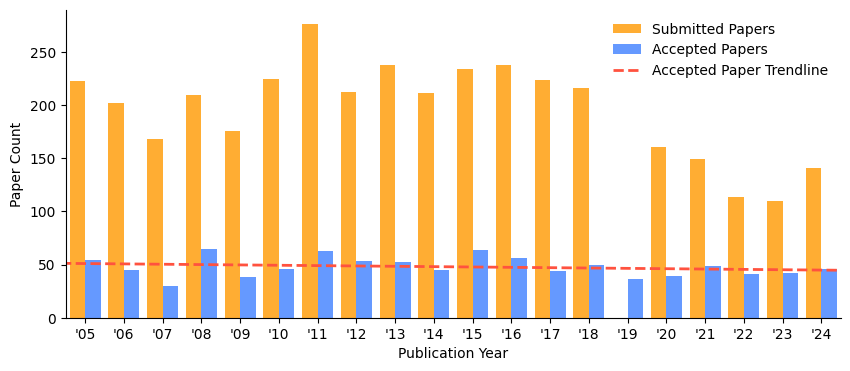

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.bar(dfYears.Year+0.2, dfYears.PaperCount, width=0.4, color=colors[3], label="Accepted Papers")
ax.bar(dfYears.Year-.2, dfYears.SubmittedPapers, width=0.4, color=colors[1], label="Submitted Papers")

ax.set_xticks(dfYears.Year, dfYears.Year.apply(lambda x: "'"+str(x)[2:]))
ax.set_xlim(dfYears.min().Year-.5, dfYears.max().Year+.5)
ax.set_xlabel("Publication Year")
ax.set_ylabel("Paper Count")

# Fit linear line
for value in ["PaperCount"]:
    dfX = dfYears[dfYears[value].notna()]
    x = dfX.Year.values - dfX.Year.min()
    m, b = np.polyfit(x, dfX[value].values, 1)
    print(f"Tenfline fit {value}: {m:.2f}x + {b:.2f}")
    x = np.array([np.min(x)-1] + list(x) + [np.max(x)+1])

    if value == "PaperCount":
        label = "Accepted Paper Trendline"

    plt.plot(x + dfX.Year.min(), m*x+b, color=colors[0], linewidth=2, ls="--", label=label)


ax.spines[['right', 'top']].set_visible(False)
#legend reverse order of lables
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, loc='upper right')
plt.savefig("./figures/paper_paperCount.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [6]:
dfYears.AcceptanceRate.describe()

count    19.000000
mean     25.573178
std       5.790237
min      17.857143
25%      21.719824
50%      23.529412
75%      29.151404
max      38.181818
Name: AcceptanceRate, dtype: float64

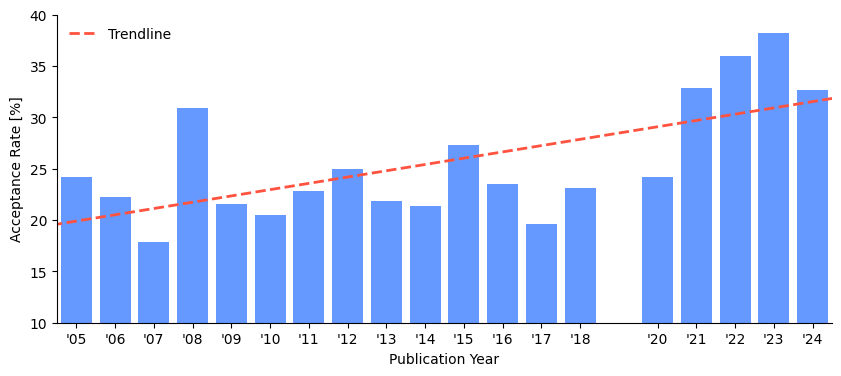

In [7]:
# Filter papers without Acceptance Rate
dfAR = dfYears[dfYears.AcceptanceRate.notna()]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.bar(dfAR.Year, dfAR.AcceptanceRate, color=colors[3])

ax.set_xticks(dfAR.Year, dfAR.Year.apply(lambda x: "'"+str(x)[2:]))
ax.set_xlim(dfAR.min().Year-.5, dfAR.max().Year+.5)
ax.set_xlabel("Publication Year")
ax.set_ylabel("Acceptance Rate [%]")
ax.set_ylim(np.floor(dfAR.AcceptanceRate.min()/10)*10, np.ceil(dfAR.AcceptanceRate.max()/10)*10)

# Fit linear line
x = dfAR.Year.values
m, b = np.polyfit(x, dfAR.AcceptanceRate.values, 1)

x = np.array([np.min(x)-1] + list(x) + [np.max(x)+1])
plt.plot(x, m*x+b, color=colors[0], linewidth=2, ls="--", label="Trendline")


ax.spines[['right', 'top']].set_visible(False)
plt.legend(frameon=False, loc='upper left')
plt.savefig("./figures/paper_acceptanceRate.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [8]:
dfLocations = pd.read_csv("./data/locations.csv")
dfLocations = pd.merge(dfLocations, gdf, left_on="Alpha-3", right_on="Alpha-3", how="left")

# Only ACM DL Accaptance Rates
dfLocations = dfLocations[dfLocations.Year >= 2005]

dfLocations = pd.merge(dfLocations, dfYears[["Year", "AcceptanceRate", "SubmittedPapers"]], left_on="Year", right_on="Year", how="outer")
dfLocations.head()

,Year,City,Alpha-3,Latitude,Longitude,Note,Country,Region,Sub-Region,geometry,AcceptanceRate,SubmittedPapers
0,2005,Salzburg,AUT,47.809490,13.055010,NaN,Austria,Europe,Western Europe,"POLYGON ((16.94504 48.60417, 16.95434 48.55740...",24.215247,223.0
1,2006,Helsinki,FIN,60.170833,24.937500,NaN,Finland,Europe,Northern Europe,"MULTIPOLYGON (((28.95408 69.02726, 28.83346 68...",22.277228,202.0
2,2007,Singapore,SGP,1.283333,103.833333,NaN,Singapore,Asia,South-eastern Asia,"POLYGON ((103.96079 1.39110, 103.98569 1.38544...",17.857143,168.0
3,2008,Enschede,NLD,52.222500,6.892500,NaN,Netherlands,Europe,Western Europe,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",30.952381,210.0
4,2009,Siegen,DEU,50.883333,8.016667,NaN,Germany,Europe,Western Europe,"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48...",21.590909,176.0


In [9]:
df_geo = geopandas.GeoDataFrame(dfLocations, geometry=geopandas.points_from_xy(dfLocations.Longitude, dfLocations.Latitude))

In [10]:
# In case we have missing values in the Acceptance Rate
df_geo[df_geo.SubmittedPapers.isna()]

,Year,City,Alpha-3,Latitude,Longitude,Note,Country,Region,Sub-Region,geometry,AcceptanceRate,SubmittedPapers
14,2019,Taipei,TWN,25.0375,121.5625,NaN,"Taiwan, Province of China",Asia,Eastern Asia,POINT (121.56250 25.03750),NaN,NaN


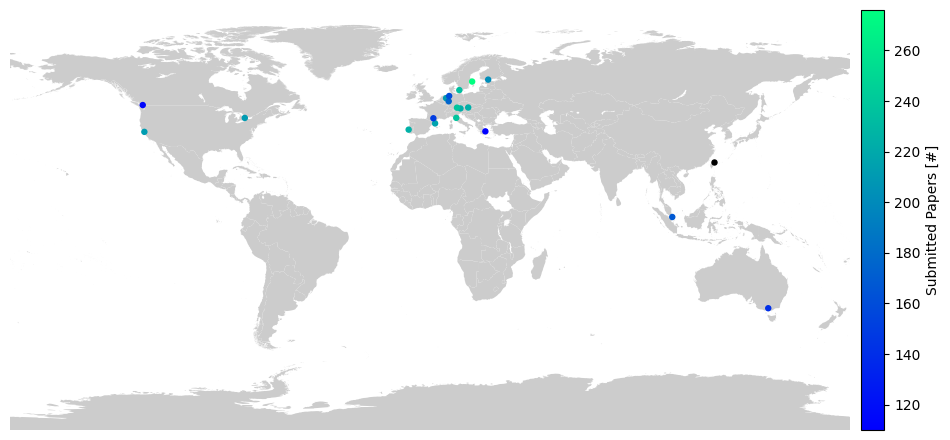

In [11]:
fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]

ax2 = gdf.plot( color='#CCCCCC', ax=ax )

df_geo.plot(ax=ax, column="SubmittedPapers", cmap='winter', markersize=13)

sm = plt.cm.ScalarMappable(cmap="winter", norm=plt.Normalize(vmin=df_geo.SubmittedPapers.min(), vmax=df_geo.SubmittedPapers.max()))
cax.clear()
cbar = fig.colorbar(sm, ax=ax, cax=cax)
cbar.set_label('Submitted Papers [#]')
cbar.ax.tick_params() 

# In case we have missing values in the Acceptance Rate
df_geo[df_geo.SubmittedPapers.isna()].plot(ax=ax, color='k', markersize=13)

ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.axis('off')

plt.savefig("./figures/paper_SubmittedPapersPerCountry.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

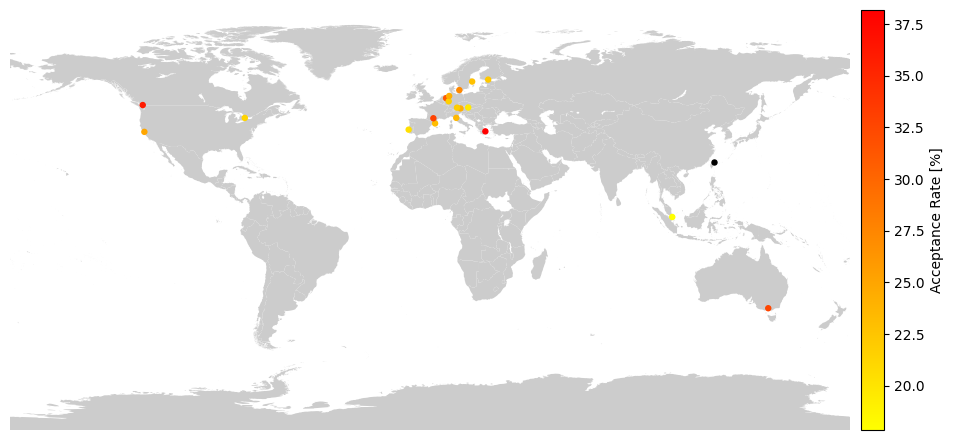

In [12]:
fig, axs = plt.subplots(1, 2,figsize=(10, 4.5), layout='tight', gridspec_kw={'width_ratios': [40, 1]})
ax = axs[0]
cax = axs[1]

ax2 = gdf.plot( color='#CCCCCC', ax=ax )

df_geo.plot(ax=ax, column="AcceptanceRate", cmap='autumn_r', markersize=13)

sm = plt.cm.ScalarMappable(cmap="autumn_r", norm=plt.Normalize(vmin=df_geo.AcceptanceRate.min(), vmax=df_geo.AcceptanceRate.max()))
cax.clear()
cbar = fig.colorbar(sm, ax=ax, cax=cax)
cbar.set_label('Acceptance Rate [%]')
cbar.ax.tick_params() 

# In case we have missing values in the Acceptance Rate
dfX = df_geo[df_geo.SubmittedPapers.isna()]
dfX.plot(ax=ax, color='k', markersize=13)


ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.axis('off')

plt.savefig("./figures/paper_acceptanceRatePerCountry.png", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()

In [13]:
df_geo.groupby("Region").AcceptanceRate.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Americas,3.0,27.4,7.6,21.3,23.2,25.0,30.5,36.0
Asia,1.0,17.9,NaN,17.9,17.9,17.9,17.9,17.9
Europe,14.0,25.2,5.3,19.6,22.0,23.3,26.6,38.2
Oceania,1.0,32.6,NaN,32.6,32.6,32.6,32.6,32.6


In [14]:
df_geo.groupby("Region").SubmittedPapers.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Americas,3.0,179.0,56.3,114.0,162.5,211.0,211.5,212.0
Asia,1.0,168.0,NaN,168.0,168.0,168.0,168.0,168.0
Europe,14.0,205.9,43.2,110.0,182.5,219.5,231.8,276.0
Oceania,1.0,141.0,NaN,141.0,141.0,141.0,141.0,141.0
